In [1]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct1'
os.chdir(new_path)


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [3]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(10, 3))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

### Control parameters

In [4]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [5]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [6]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


In [7]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [8]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)


### View structure

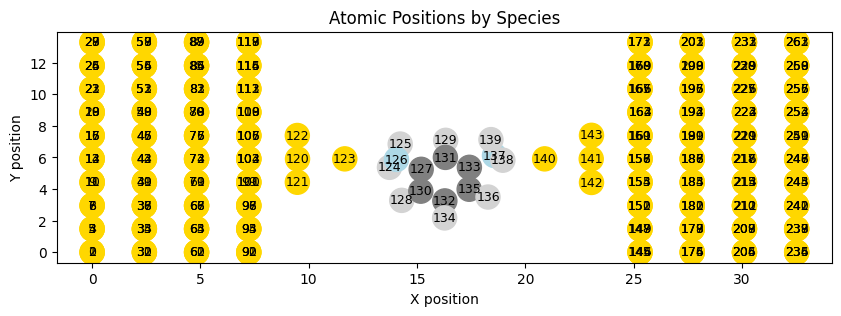

In [9]:
element_colors = {
    "Au": "gold",
    "C": "gray",
    'H': 'lightgray',
    'N': 'lightblue'
}

plot_atomic_positions_by_species(atoms, element_colors)

## LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

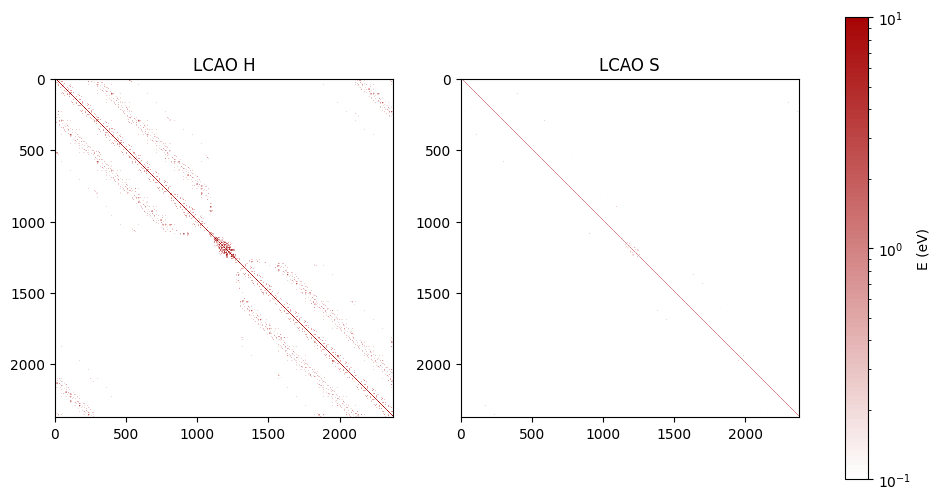

In [10]:
# Plot the Hamiltonian and overlap matrix of the scattering region obtained from gpaw. Note that at this point, the PBC has not been removed.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cax1 = ax1.imshow(np.abs(H_lcao), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("LCAO H")

cax2 = ax2.imshow(np.abs(S_lcao), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("LCAO S")

cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')
plt.show()


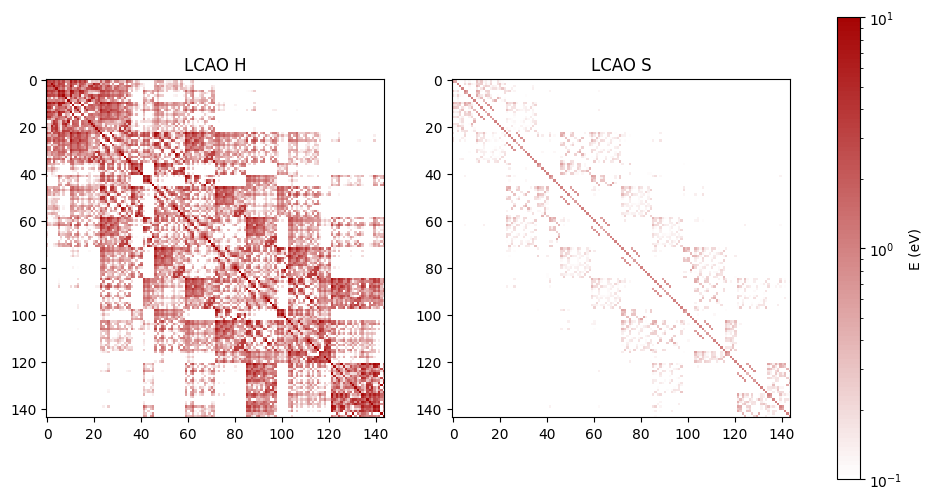

In [11]:
# Zoom in on the molecule in the Hamiltonian and overlap matrix

# Extract the bridge regions
bridge_region_H_lcao = H_lcao[bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_lcao = S_lcao[bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bridge region of H_lcao
cax1 = ax1.imshow(np.abs(bridge_region_H_lcao), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("LCAO H")

# Plot the bridge region of S_lcao
cax2 = ax2.imshow(np.abs(bridge_region_S_lcao), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("LCAO S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()


### Subdiagonalize C, N and H of Hamiltonian 

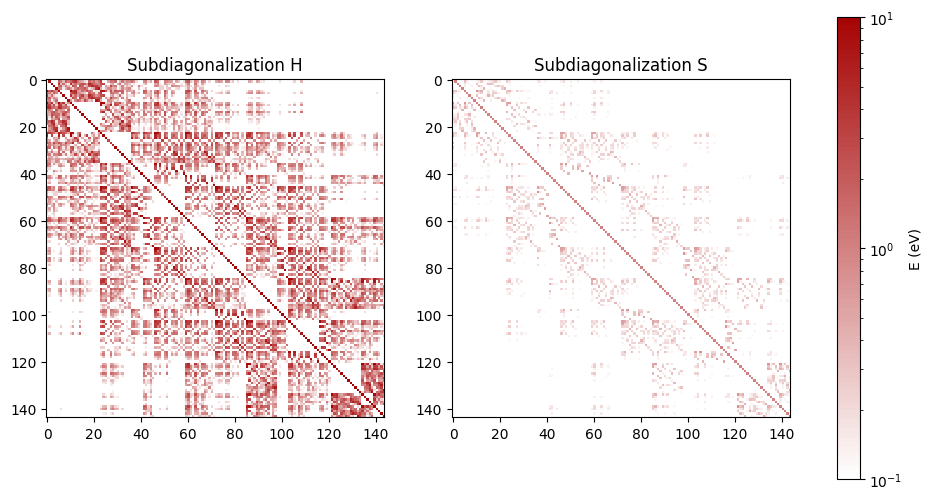

In [12]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_sub_device = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None, ...]

# Extract the bridge regions
bridge_region_H_sub = H_sub_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


### Compute and plot transmission function

In [13]:
# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)

# Initialize self-energy list for left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0], len(leads_atoms.repeat(Nr)))

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_sub_device[0], S_sub_device[0])

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-2., 2. + de / 2., de).round(7)
eta = 1e-3

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='coupling',
                                 eta=eta)

# Calculate the transmission function T for each energy in the defined range
T = np.empty(energies.size)
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point


[0, 810, 1116, 1260, 1566, 2376]


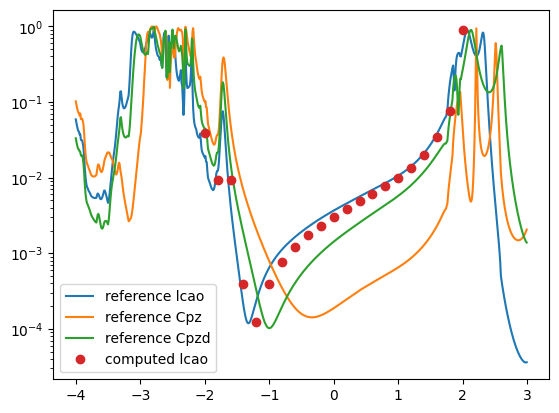

In [14]:
# Define the path to the reference data for transmission
ref_path = "published_reference/transmission"

# Load the reference LCAO transmission data from a file, where reference is the data from "Smart Local Orbitals paper"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_Cpz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_Cpzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed lcao")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")

plt.legend()


### Conclusion:
- I am able to reproduce the transmission function that is in the paper if I use the Hamiltonian in the LCAO basis from GPAW and perform a subdiagonalization on C, N and H. I observe a shift of the transmission, possibly related to a different Fermi level alignment. It should not be concerning, but any feedback in this regard is also welcome.

### Subdiagonalize only C (Seems to be what the paper suggests to do) and look at T(E) 

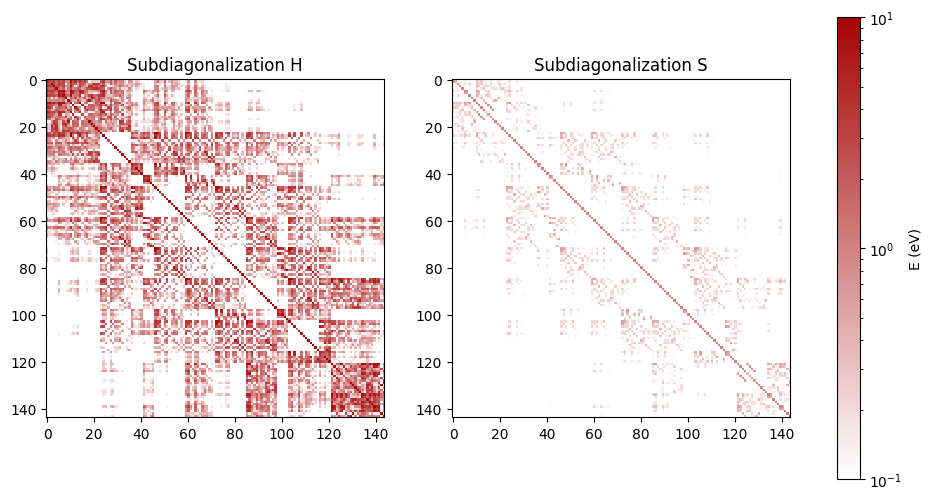

In [15]:
# Define the species for subdiagonalization
SUBDIAG_SPECIES = ("C")

# Get the indices of atoms corresponding to the specified species in the basis
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices using the selected species
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the Hamiltonian and overlap matrices using the subdiagonalization matrix
H_sub_device = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None, ...]

# Extract the bridge region from the subdiagonalized Hamiltonian and overlap matrices
bridge_region_H_sub = H_sub_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonalized overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')
plt.show()


### Compute and plot transmission function

[0, 810, 1116, 1219, 1260, 1566, 2376]


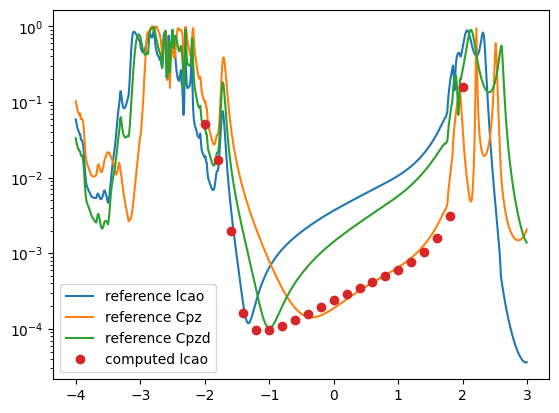

In [16]:
# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices)
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_sub_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Partition the device Hamiltonian matrix into tridiagonal nodes
nodes = graph_partition.get_tridiagonal_nodes(
    device_basis,
    H_sub_device[0],
    len(leads_atoms.repeat(Nr))
)

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_sub_device[0],
    S_sub_device[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed lcao")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")

plt.legend()

### Conclusion

- If I use the Hamiltonian in the LCAO basis from GPAW and perform a subdiagonalization only on C, I am unable to reproduce the transmission function.

### Question

- How should the script be modified such that if I subdiagonalize only C, I still get the right T(E)?

### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C 2pz and all N orbitals are considered to be the active region. 

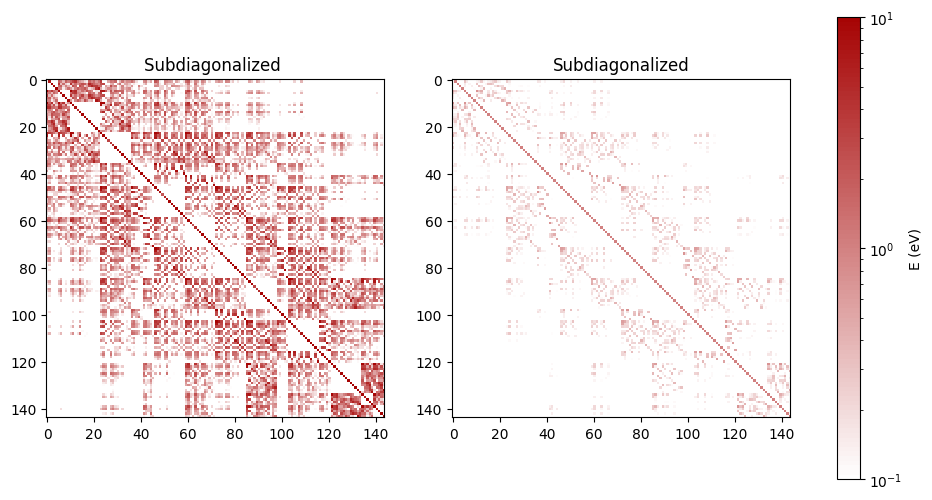

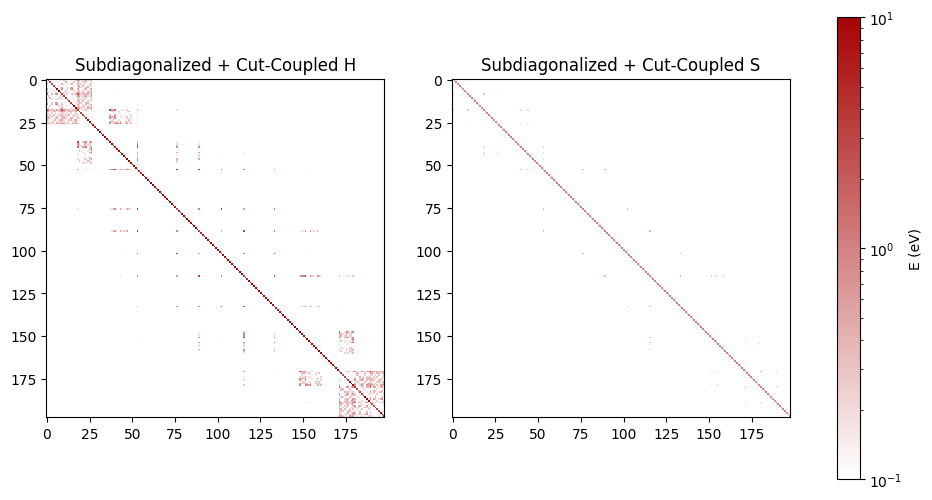

[0, 810, 1116, 1260, 1566, 2376]


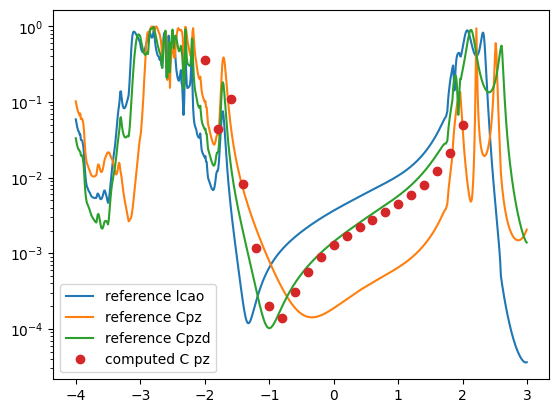

In [25]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sub_device = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3, 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled_device[0], S_cutcoupled_device[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled_device[0, bridge_start-27:bridge_end+1+27, bridge_start-27:bridge_end+1+27]
bridge_region_S_cut = S_cutcoupled_device[0, bridge_start-27:bridge_end+1+27, bridge_start-27:bridge_end+1+27]

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(H_sub_device[0,bridge_start:bridge_end+1, bridge_start:bridge_end+1]), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized ")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_sub_device[0,bridge_start:bridge_end+1, bridge_start:bridge_end+1]), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()

# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)


nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0], len(leads_atoms.repeat(Nr)))

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_cutcoupled_device[0],
    S_cutcoupled_device[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point


# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed C pz")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")

plt.legend()

### Conclusion
- After the cut coupling procedure, I am unable to reproduce the C pz (orange) curve from the paper.

### Question
- What is missing in the above computation of the T(E) from a cut coupled Hamiltonian to reproduce the curve from the paper?

### Use C to subdiagonalize and look at the effect of cut-coupling where C pz and all N orbitals are considered to be the active region 

[ 3 16 29 42 55 68]
[1142 1165 1178 1191 1204 1222]


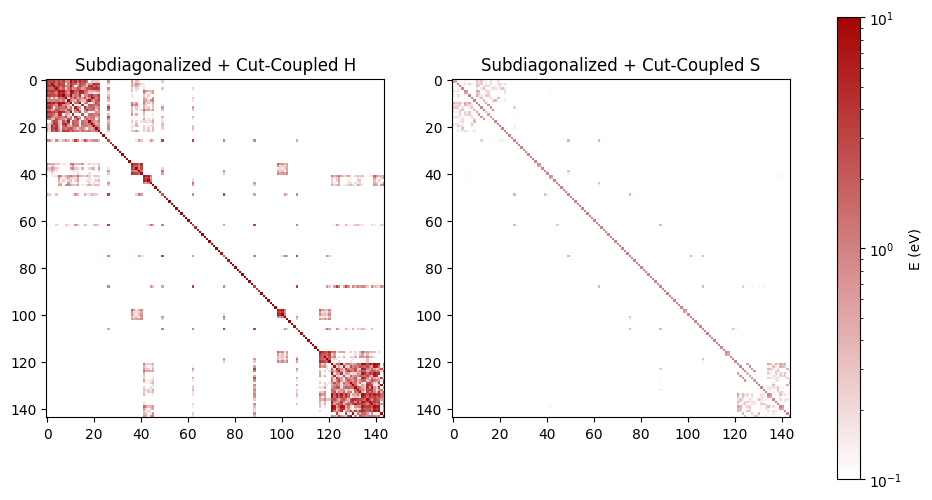

[0, 810, 1116, 1260, 1566, 2376]


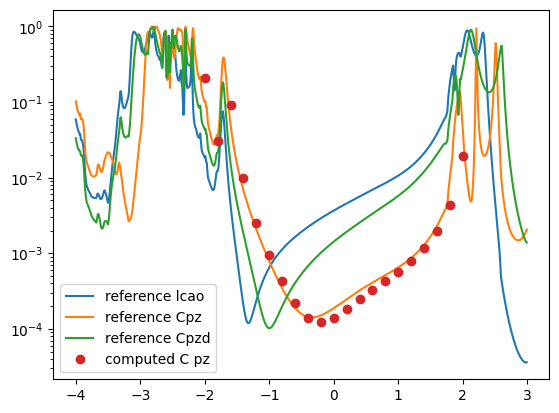

In [19]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sub_device = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3}#, 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]
print(extract_active_region)
print(index_active_region)
# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled_device[0], S_cutcoupled_device[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

# Display the plots
plt.show()

# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = [0, 810, 1116, 1260, 1566, 2376]

# Print the nodes to verify the partitioning
print(nodes)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_cutcoupled_device[0],
    S_cutcoupled_device[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point


# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed C pz")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")

plt.legend()

### Conclusion
- I am able to reproduce the C pz (orange) curve if 
    - I diagonalize only C. I can't reproduce the plot if I start from a Hamiltonian where C,N and H are subdiagonalized.
    - I don't compute the nodes automatically from the Hamiltonian where only C is subdiagonalize. Instead, I hard code the nodes to [0, 810, 1116, 1260, 1566, 2376]. This hard coded nodes are the ones obtained from a Hamiltonian where C, N and H are subdiagonalized.
    - and then do the cut coupling procedure
IMPORTANT: It seems like the nodes should ALWAYS and ONLY be computed from the Hamiltonian where ALL THE ELEMENTS in the BRIDGE are subdiagonalized.

### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C pzd and all N orbitals are considered to be the active region 

In [20]:
# Define indices for external and internal carbon atoms and the active orbitals for each set
external_C_indices = [127, 133]  # Indices of external carbon atoms
internal_C_indices = [130, 131, 132, 135]  # Indices of internal carbon atoms
kind = 'C'  # Atom type (Carbon)
active_ext_C = {kind: [3, 6, 7, 10, 12]}  # Active orbitals for external carbon atoms
active_int_C = {kind: [3, 6, 10, 12]}  # Active orbitals for internal carbon atoms

# Search for all atoms of the specified kind (Carbon) in the atomic structure
search_result = atoms.symbols.search(kind)

# Compute cumulative sum of the number of atomic orbitals for each atom, used for indexing
M_a = np.cumsum(np.insert(nao_a[:-1], 0, 0))

# Initialize an empty list to store the indices of the selected active orbitals
idxlist = []

# Loop over each atom found in the search result
for a in search_result:
    if a in external_C_indices:
        # If the atom is in the external carbon indices, add the active external orbitals to the list
        idxlist.extend(M_a[a] + np.array(active_ext_C[kind]))
    elif a in internal_C_indices:
        # If the atom is in the internal carbon indices, add the active internal orbitals to the list
        idxlist.extend(M_a[a] + np.array(active_int_C[kind]))

# Convert the list of indices to a NumPy array
idxlist = np.asarray(idxlist)

# Sort the list of indices to ensure proper order
idxlist.sort()

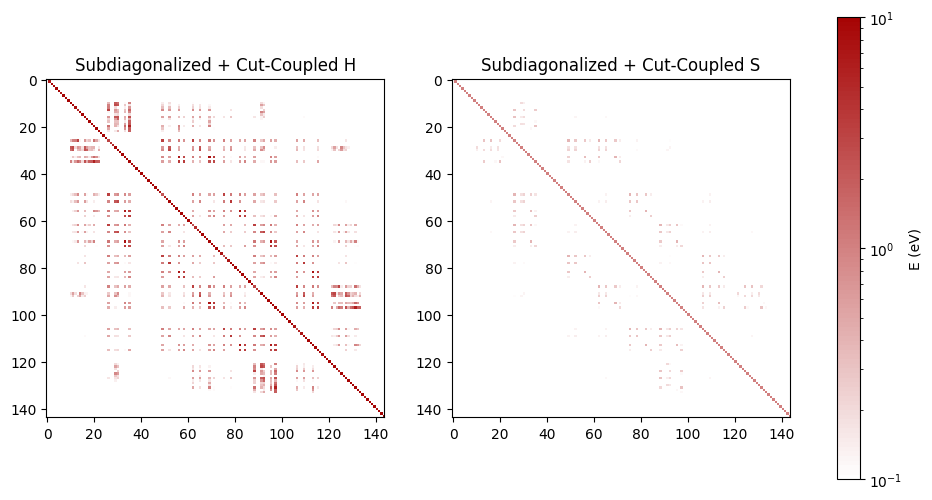

[0, 810, 1116, 1260, 1566, 2376]


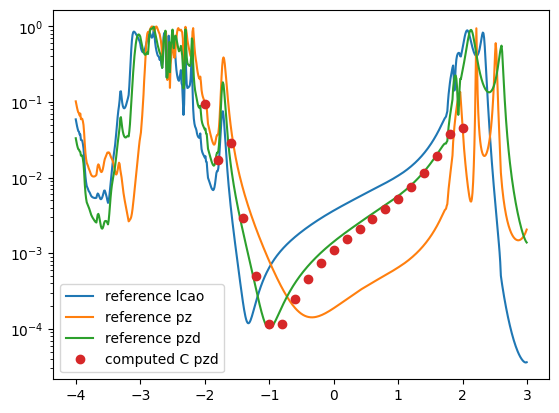

In [21]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sub_device = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species (for Nitrogen in this case)
active_N = {'N': [0,1,2,3,4,5,6,7,8,9,10,11,12]}
extract_active_region = basis_subdiag_region.extract().take(active_N)
index_active_region = index_subdiag_region[extract_active_region]

# Concatenate the previously obtained idxlist with the new active region indices and sort them
index_active_region = np.concatenate((idxlist, index_active_region))
index_active_region.sort()

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled_device[0], S_cutcoupled_device[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()

# Prepare the k-points and Hamiltonian/overlap matrices for the leads based on the cut-coupled device Hamiltonian
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

# Initialize the self-energy matrices for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the left and right leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Define the partitioning nodes for the device Hamiltonian and overlap matrices
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0], len(leads_atoms.repeat(Nr)))

# Tridiagonalize the Hamiltonian and overlap matrices using the defined nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes,
    H_cutcoupled_device[0],
    S_cutcoupled_device[0]
)

# Print the nodes to verify the partitioning
print(nodes)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:, 0], Tref_lcao[:, 1], label="reference lcao")

# Plot the reference PZ transmission data
plt.plot(Tref_Cpz[:, 0], Tref_Cpz[:, 1], label="reference pz")

# Plot the reference PZD transmission data
plt.plot(Tref_Cpzd[:, 0], Tref_Cpzd[:, 1], label="reference pzd")

# Plot the computed transmission data for the cut-coupled device (C pzd)
plt.plot(energies, T, 'o', label="computed C pzd")

# Set the y-axis to a logarithmic scale for better visualization of transmission data
plt.yscale("log")

plt.legend()


### Proceed with using only C to subdiagonalize and look at the effect of cut-coupling where C pzd and all N orbitals are considered to be the active region 

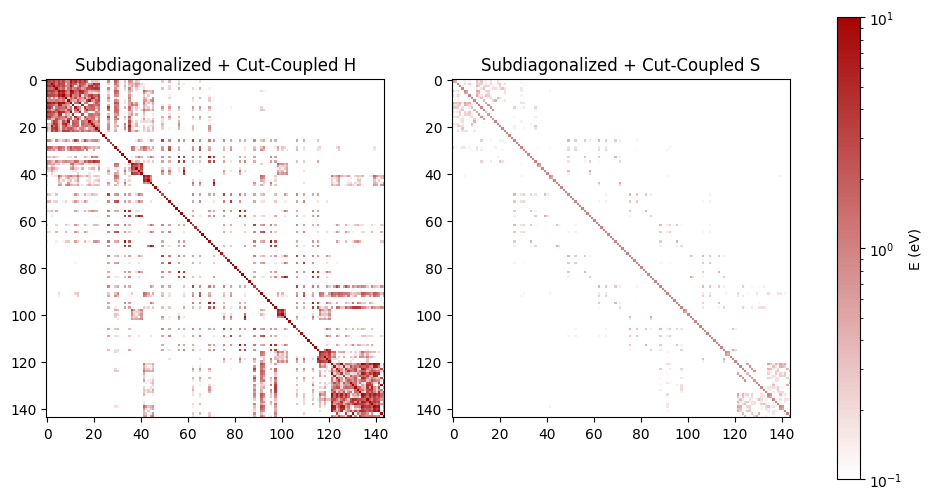

[0, 810, 1116, 1260, 1566, 2376]


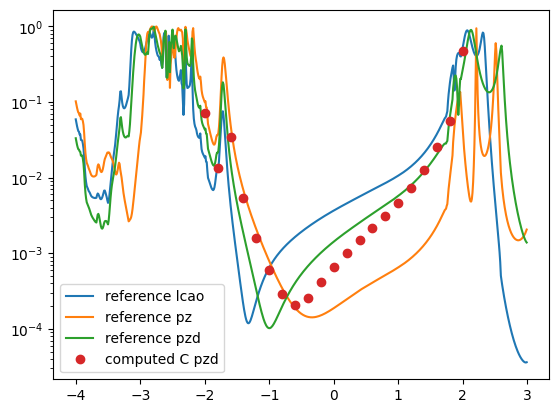

In [24]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sub_device = rotate_matrix(H_lcao, Usub)[None, ...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled_device = deepcopy(H_sub_device)
S_cutcoupled_device = deepcopy(S_sub_device)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Concatenate the previously obtained idxlist with the new active region indices and sort them
index_active_region = idxlist
index_active_region.sort()

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled_device[0], S_cutcoupled_device[0], index_inactive_region)

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_cut = S_cutcoupled_device[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]

# Create a figure with two subplots side by side for the Hamiltonian and overlap matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Add a shared colorbar for both subplots
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()

# Prepare the k-points and Hamiltonian/overlap matrices for the leads based on the cut-coupled device Hamiltonian
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled_device[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_cutcoupled_device)
remove_pbc(device_basis, S_cutcoupled_device)

# Initialize the self-energy matrices for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the left and right leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Define the partitioning nodes for the device Hamiltonian and overlap matrices
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0], len(leads_atoms.repeat(Nr)))

nodes = [0, 810, 1116, 1260, 1566, 2376]
# Print the nodes to verify the partitioning
print(nodes)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:, 0], Tref_lcao[:, 1], label="reference lcao")

# Plot the reference PZ transmission data
plt.plot(Tref_Cpz[:, 0], Tref_Cpz[:, 1], label="reference pz")

# Plot the reference PZD transmission data
plt.plot(Tref_Cpzd[:, 0], Tref_Cpzd[:, 1], label="reference pzd")

# Plot the computed transmission data for the cut-coupled device (C pzd)
plt.plot(energies, T, 'o', label="computed C pzd")

# Set the y-axis to a logarithmic scale for better visualization of transmission data
plt.yscale("log")

plt.legend()


### Conclusion 

- I am also able to reproduce the C pzd (green) curve that is presented in the paper if I start from a Hamiltonian where C,N and H are all subdiagonalized. 
- However, it cannot be reproduced if I start from a Hamiltonian where only C atoms are subdiagonalized. 


### Other questions to possibly include for future discussions, low priority?

- The dimension of the Hamiltonian and overlap matrix remain the same as the original LCAO H and S after the cut-coupling procedure. So, how is the speed up that can be obtained by cut-coupling achieved?

- In the 1,3 AuBDA structure presented in this notebook, I am able to reproduce at least the LCAO transmission function. I have another structure file which is identical to the structure that is presented in this notebook, the only difference is that I have less number of Au atoms in the scattering region as shown in the figure below. In this case, I am unable to reproduce even the LCAO transmission function. 

    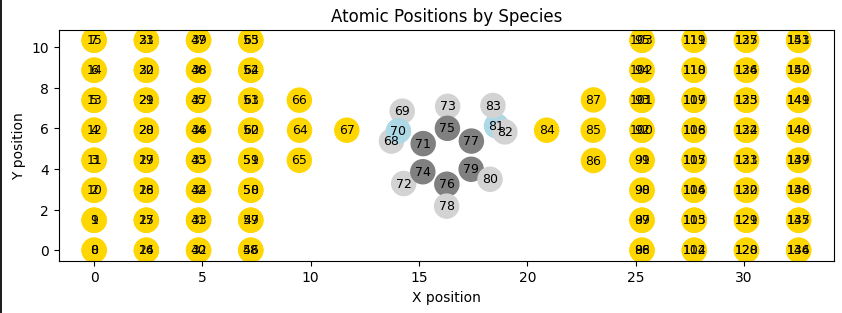

    - Is there a certain number of Au atoms that has to exist in the scattering region for the code to work? 
    - Is it possible that in the case of the structure shown above, since the Nr for the unit cell in (1,4,2), the code does not work well? Am I able to reproduce the lcao transmission for the structure in this notebook because Nr is (1,5,3)? In other words, does the code work better for odd number repetitions in Nr? What is the minimum image convention mentioned in the  "Efficient partitioning of surface Green’s function: toward ab initio contact resistance study."? 


